In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import urllib

In [2]:
df = pd.read_csv('solar_panels.csv')

In [3]:
df['date'] = df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

In [4]:
df.head()

,date,solar_produced_per_day,daylight,daylight_avg_temp,avg_cloudcover,avg_direct_radiation,weather,max_wind_speed,max_temp
0,2011-10-27,10.1,600.0,14.7,45.5,75.0,3,17.1,16.1
1,2011-10-28,10.0,597.0,16.0,16.5,143.0,3,9.1,17.4
2,2011-10-29,9.4,593.0,15.3,75.0,25.0,51,11.5,17.4
3,2011-10-30,4.6,589.0,15.1,91.5,49.0,3,15.3,16.2
4,2011-10-31,3.8,587.0,15.0,60.5,47.5,3,12.3,15.9


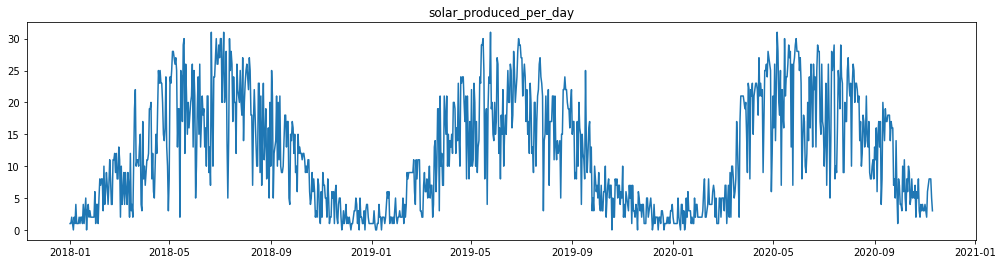

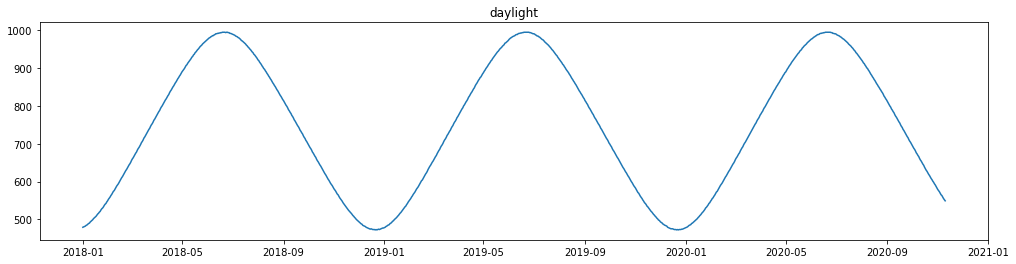

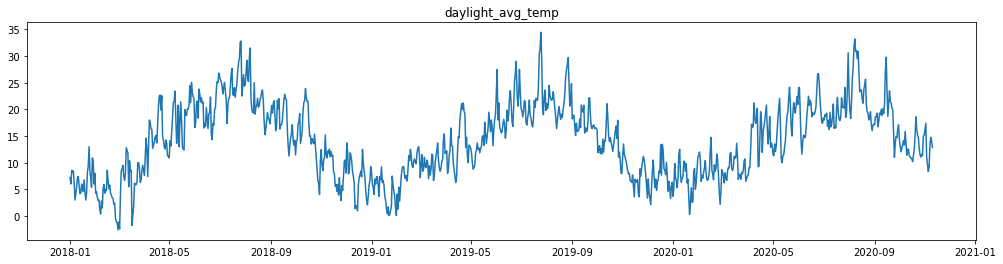

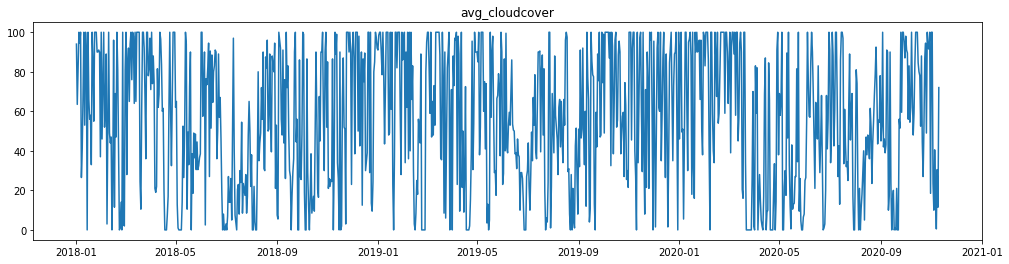

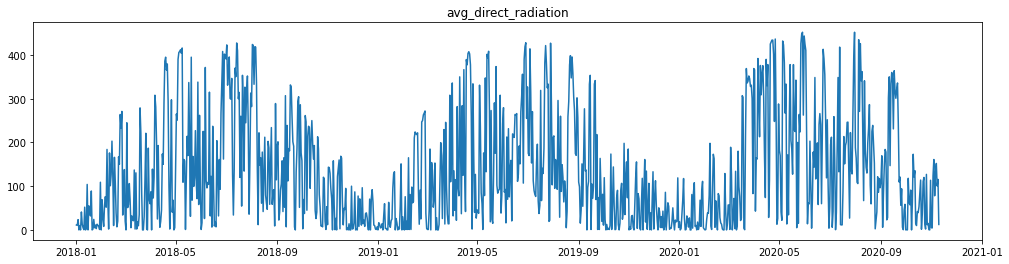

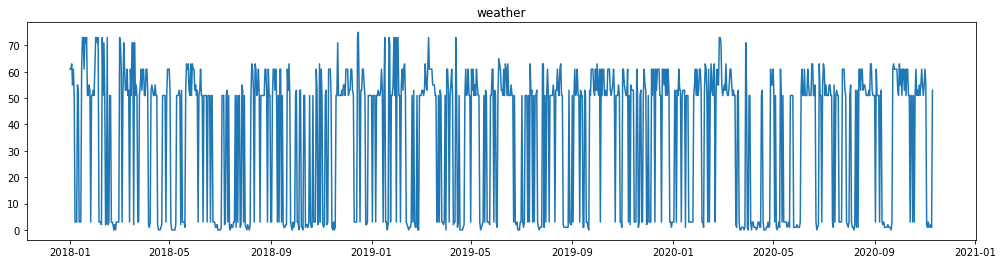

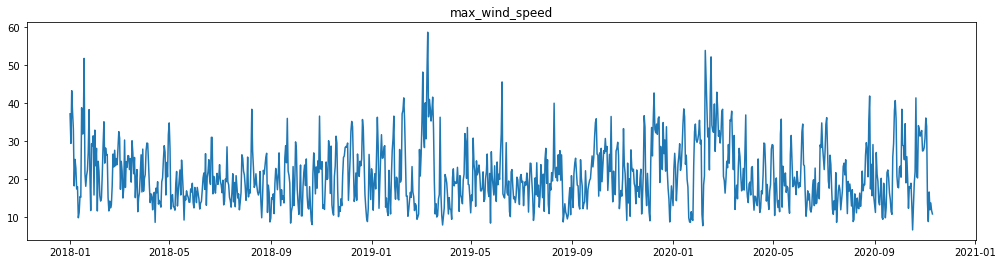

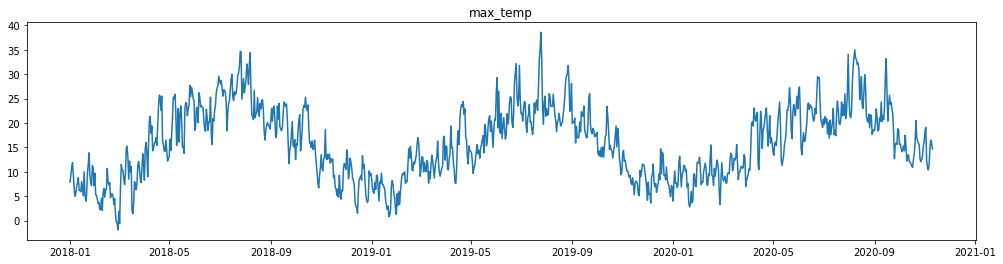

In [5]:
columns = list(df.columns)
columns.remove('date')
start_date = datetime(2018, 1, 1)
end_date = datetime(2020, 11, 10)
plot_year= df[(df['date'] >= start_date) & (df['date'] <= end_date) ]
for column in columns:
    
    plt.figure().set_figwidth(17)
    plt.title(column)
    plt.plot(plot_year['date'].to_numpy(),plot_year[column].to_numpy())
    plt.show()

#### We can either make it as time-series problem or regression problem. I'll stick to regression.
To do that, I'll make a new column with only months so there's still some imformation from data column.

In [6]:
df = df[(df['date'] < datetime(2021, 1, 1))]
df['month'] = df['date'].apply(lambda x: int(x.strftime('%m')))
df = df.drop('date', axis=1)


In [7]:
from sklearn.model_selection import train_test_split

target = df['solar_produced_per_day']
X = df.drop('solar_produced_per_day', axis=1)

X, X_test, y, y_test = train_test_split(X, target, test_size=0.1, random_state=723)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
num_cols = ['daylight', 
            'daylight_avg_temp', 'avg_cloudcover', 
            'avg_direct_radiation',
            'max_wind_speed', 'max_temp']
scalers = {}
oe = OrdinalEncoder()
def preprocess(df, train=True):
    for col in num_cols:
        if train:
            scalers[col] = StandardScaler()
            df[col] = scalers[col].fit_transform(df[col].to_numpy().reshape(-1,1))
        else:
            df[col] = scalers[col].fit_transform(df[col].to_numpy().reshape(-1,1))

    if train:
        df['weather'] = oe.fit_transform(df['weather'].to_numpy().reshape(-1,1))
    else:
        df['weather'] = oe.fit_transform(df['weather'].to_numpy().reshape(-1,1))

    
    
preprocess(X)
preprocess(X_test, train=False)

### I chose Random Forest as the model because it handles nonlinearity and I don't need a lot of interpretability for this project. If more interpretability is needed, decision tree might be a better pick.

In [9]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=530, max_depth=6, random_state=41)

#### Feature importance of Random Forest

<BarContainer object of 8 artists>

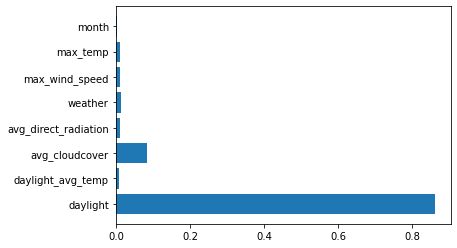

In [10]:
rf.fit(X, y)

plt.barh(rf.feature_names_in_, rf.feature_importances_)

### Cross validation

In [11]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True, random_state=1)

Since data has many outliers MAE is better as a evaluation metrics beacause is more robust againts outliers.

In [12]:
from sklearn.metrics import mean_absolute_error

losses = []
models = []
for train_idx, test_idx in kf.split(X, y):
    model = rf
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    prediction = model.predict(X.iloc[test_idx])
    loss = mean_absolute_error(prediction, y.iloc[test_idx])
    losses.append(loss)
    models.append(model)

print(f"MEAN: {np.mean(losses)}, STD: {np.std(losses)}")



MEAN: 3.28779013118927, STD: 0.07025206883192793


### Final Prediction

In [13]:
predictions = []
for model in models:
    test_prediction = model.predict(X_test)
    predictions.append(test_prediction)

mean_absolute_error(y_test, np.mean(predictions, axis=0))

3.320742515630641

### Notes

  - dropping `month` didn't improve score
  - base Random Forest is wrong on average by 3.38 KWh per day
  - after fine-tuning it drops to 3.29 KWh per day
  - on test data the final score is 3.32 KWh per day